In [1]:
#These lines set up inline plotting, and apply a standard size
%matplotlib inline
import matplotlib
matplotlib.rc('font', **{'size': 15})

Let's look at a summary of the # of queued files over a period of time. Using a boxplot (similar to LatencySummary notebook), we can look at the files-queued distribution of each link over time to get a feel for how stable each link's queueing is. This uses the es-atlas.cern.ch instance of Kibana, and requires authentication.

Look at exponential fitting of the queueing data.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from elasticsearch import Elasticsearch, exceptions as es_exceptions

#Create instance of ElasticSearch using the Atlas host server
es = Elasticsearch(hosts=[{'host':'es-atlas.cern.ch', 'port':9202}],
                   http_auth=('es-atlas', 'v~$&<J8/cG9]*eQ@'),
                   timeout=60)

In [3]:
#Find names of all links that have BNL-ATLAS as the source
query = {
  "size": 0,
  "query": {
    "filtered": {
      "query": {
        "query_string": {
          "query": "src:BNL-ATLAS",
          "analyze_wildcard": True
        }
      },
      "filter": {
        "bool": {
          "must": [
            {
              "range": {
                "timestamp": {
                  "gte": 1468221663501,
                  "lte": 1468826463501,
                  "format": "epoch_millis"
                }
              }
            }
          ],
          "must_not": []
        }
      }
    }
  },
  "aggs": {
    "2": {
      "terms": {
        "field": "dst",
        "size": 1000,
        "order": {
          "1": "desc"
        }
      },
      "aggs": {
        "1": {
          "avg": {
            "field": "queued-total"
          }
        }
      }
    }
  }
}

In [4]:
response = es.search(index="atlas_ddm-metrics*", body=query, request_timeout=600)

sites = []
for r in response['aggregations']['2']['buckets']:
    #Get field value and timestamp
    sites.append(r['key'])
print(sites)

['IFIC-LCG2', 'CERN-PROD', 'mainzgrid', 'BNL-ATLAS', 'MPPMU', 'UKI-SOUTHGRID-RALPP', 'TOKYO-LCG2', 'MWT2', 'NIKHEF-ELPROD', 'RO-07-NIPNE', 'BNL-AWSEAST', 'UKI-SCOTGRID-DURHAM', 'DESY-HH', 'ifae', 'TRIUMF-LCG2', 'TECHNION-HEP', 'IN2P3-CC', 'INFN-COSENZA', 'GRIF-LPNHE', 'LRZ-LMU', 'INFN-ROMA1', 'UKI-LT2-RHUL', 'wuppertalprod', 'CA-SCINET-T2', 'IN2P3-LAPP', 'AGLT2', 'IN2P3-LPSC', 'CA-MCGILL-CLUMEQ-T2', 'UKI-NORTHGRID-LANCS-HEP', 'NDGF-T1', 'UKI-NORTHGRID-LIV-HEP', 'DESY-ZN', 'UAM-LCG2', 'GRIF-IRFU', 'praguelcg2', 'RAL-LCG2', 'UKI-SCOTGRID-GLASGOW', 'RRC-KI-T1', 'SWT2_CPB', 'BEIJING-LCG2', 'UKI-NORTHGRID-SHEF-HEP', 'IN2P3-LPC', 'CA-VICTORIA-WESTGRID-T2', 'INFN-T1', 'WT2', 'Taiwan-LCG2', 'pic', 'FZK-LCG2', 'GR-12-TEIKAV', 'UKI-SOUTHGRID-SUSX', 'GoeGrid', 'UKI-LT2-QMUL', 'Australia-ATLAS', 'BU_ATLAS_Tier2', 'INFN-NAPOLI-ATLAS', 'ANLASC', 'UNI-FREIBURG', 'RU-Protvino-IHEP', 'RO-14-ITIM', 'GRIF-LAL', 'ITEP', 'LUCILLE', 'SFU-LCG2', 'RO-16-UAIC', 'OU_OCHEP_SWT2', 'SMU_HPC', 'OUHEP_OSG', 'IEPSAS-

In [5]:
len(sites)

162

In [27]:
import ast

query = '''{
  "size": 0,
  "query": {
    "filtered": {
      "query": {
        "query_string": {
          "query": "src:BNL-ATLAS AND dst:%s",
          "analyze_wildcard": True,
          "lowercase_expanded_terms": False
        }
      },
      "filter": {
        "bool": {
          "must": [
            {
              "range": {
                "timestamp": {
                  "gte": 1468533600000,
                  "lte": 1468792800000,
                  "format": "epoch_millis"
                }
              }
            }
          ],
          "must_not": []
        }
      }
    }
  },
  "aggs": {
    "2": {
      "date_histogram": {
        "field": "timestamp",
        "interval": "1h",
        "time_zone": "Europe/Berlin",
        "min_doc_count": 1,
        "extended_bounds": {
          "min": 1468533600000,
          "max": 1468792800000
        }
      },
      "aggs": {
        "1": {
          "avg": {
            "field": "%s"
          }
        }
      }
    }
  }
}'''


Since the atlas_ddm-metrics indices have just recently started filling, I can only look at
data from a 24-hour period currently. I am going to compare the three different gauges of
throughput: FAX, dashboard readout, and FTS.

In [28]:
#Initialize containers for three different throughput and corresponding timestamp values

totalQueuedData = []
totalTimestamp = []

for i in range(len(sites)):
    queuingQuery = ast.literal_eval(query%(sites[i],'queued-total'))    
    queuedResponse = es.search(index="atlas_ddm-metrics*", body=queuingQuery, request_timeout=600) 
    
    
    queuedData = []
    queuedTimestamp = []

    
    for r in queuedResponse['aggregations']['2']['buckets']:
        #Get field value and timestamp
        queuedData.append(r['1']['value'])
        queuedTimestamp.append(r['key'])

## remove value/key pairs that are empty (Turn this into function to save space?)  ##      
    queuedData = np.array(queuedData,dtype=np.float)
    queuedTimestamp =  np.array(queuedTimestamp,dtype=np.float) 
    indices = np.logical_not(np.isnan(queuedData))


    queuedData = queuedData[indices]
    queuedTimestamp = queuedTimestamp[indices]

    totalQueuedData.append(queuedData)
    totalTimestamp.append(queuedTimestamp)
    if i%10 == 0:
        print(i)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160


In [35]:
#Initialize containers for three different throughput and corresponding timestamp values

totalDoneData = []
totalDoneTimestamp = []

for i in range(len(sites)):
    doneQuery = ast.literal_eval(query%(sites[i],'done-total-6h'))    
    queuedResponse = es.search(index="atlas_ddm-metrics*", body=doneQuery, request_timeout=600) 
    
    
    doneData = []
    doneTimestamp = []

    
    for r in queuedResponse['aggregations']['2']['buckets']:
        #Get field value and timestamp
        doneData.append(r['1']['value'])
        doneTimestamp.append(r['key'])

## remove value/key pairs that are empty (Turn this into function to save space?)  ##      
    doneData = np.array(doneData,dtype=np.float)
    doneTimestamp =  np.array(doneTimestamp,dtype=np.float) 
    indices = np.logical_not(np.isnan(doneData))


    doneData = doneData[indices]
    doneTimestamp = doneTimestamp[indices]

    totalDoneData.append(doneData)
    totalDoneTimestamp.append(doneTimestamp)
    if i%10 == 0:
        print(i)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160


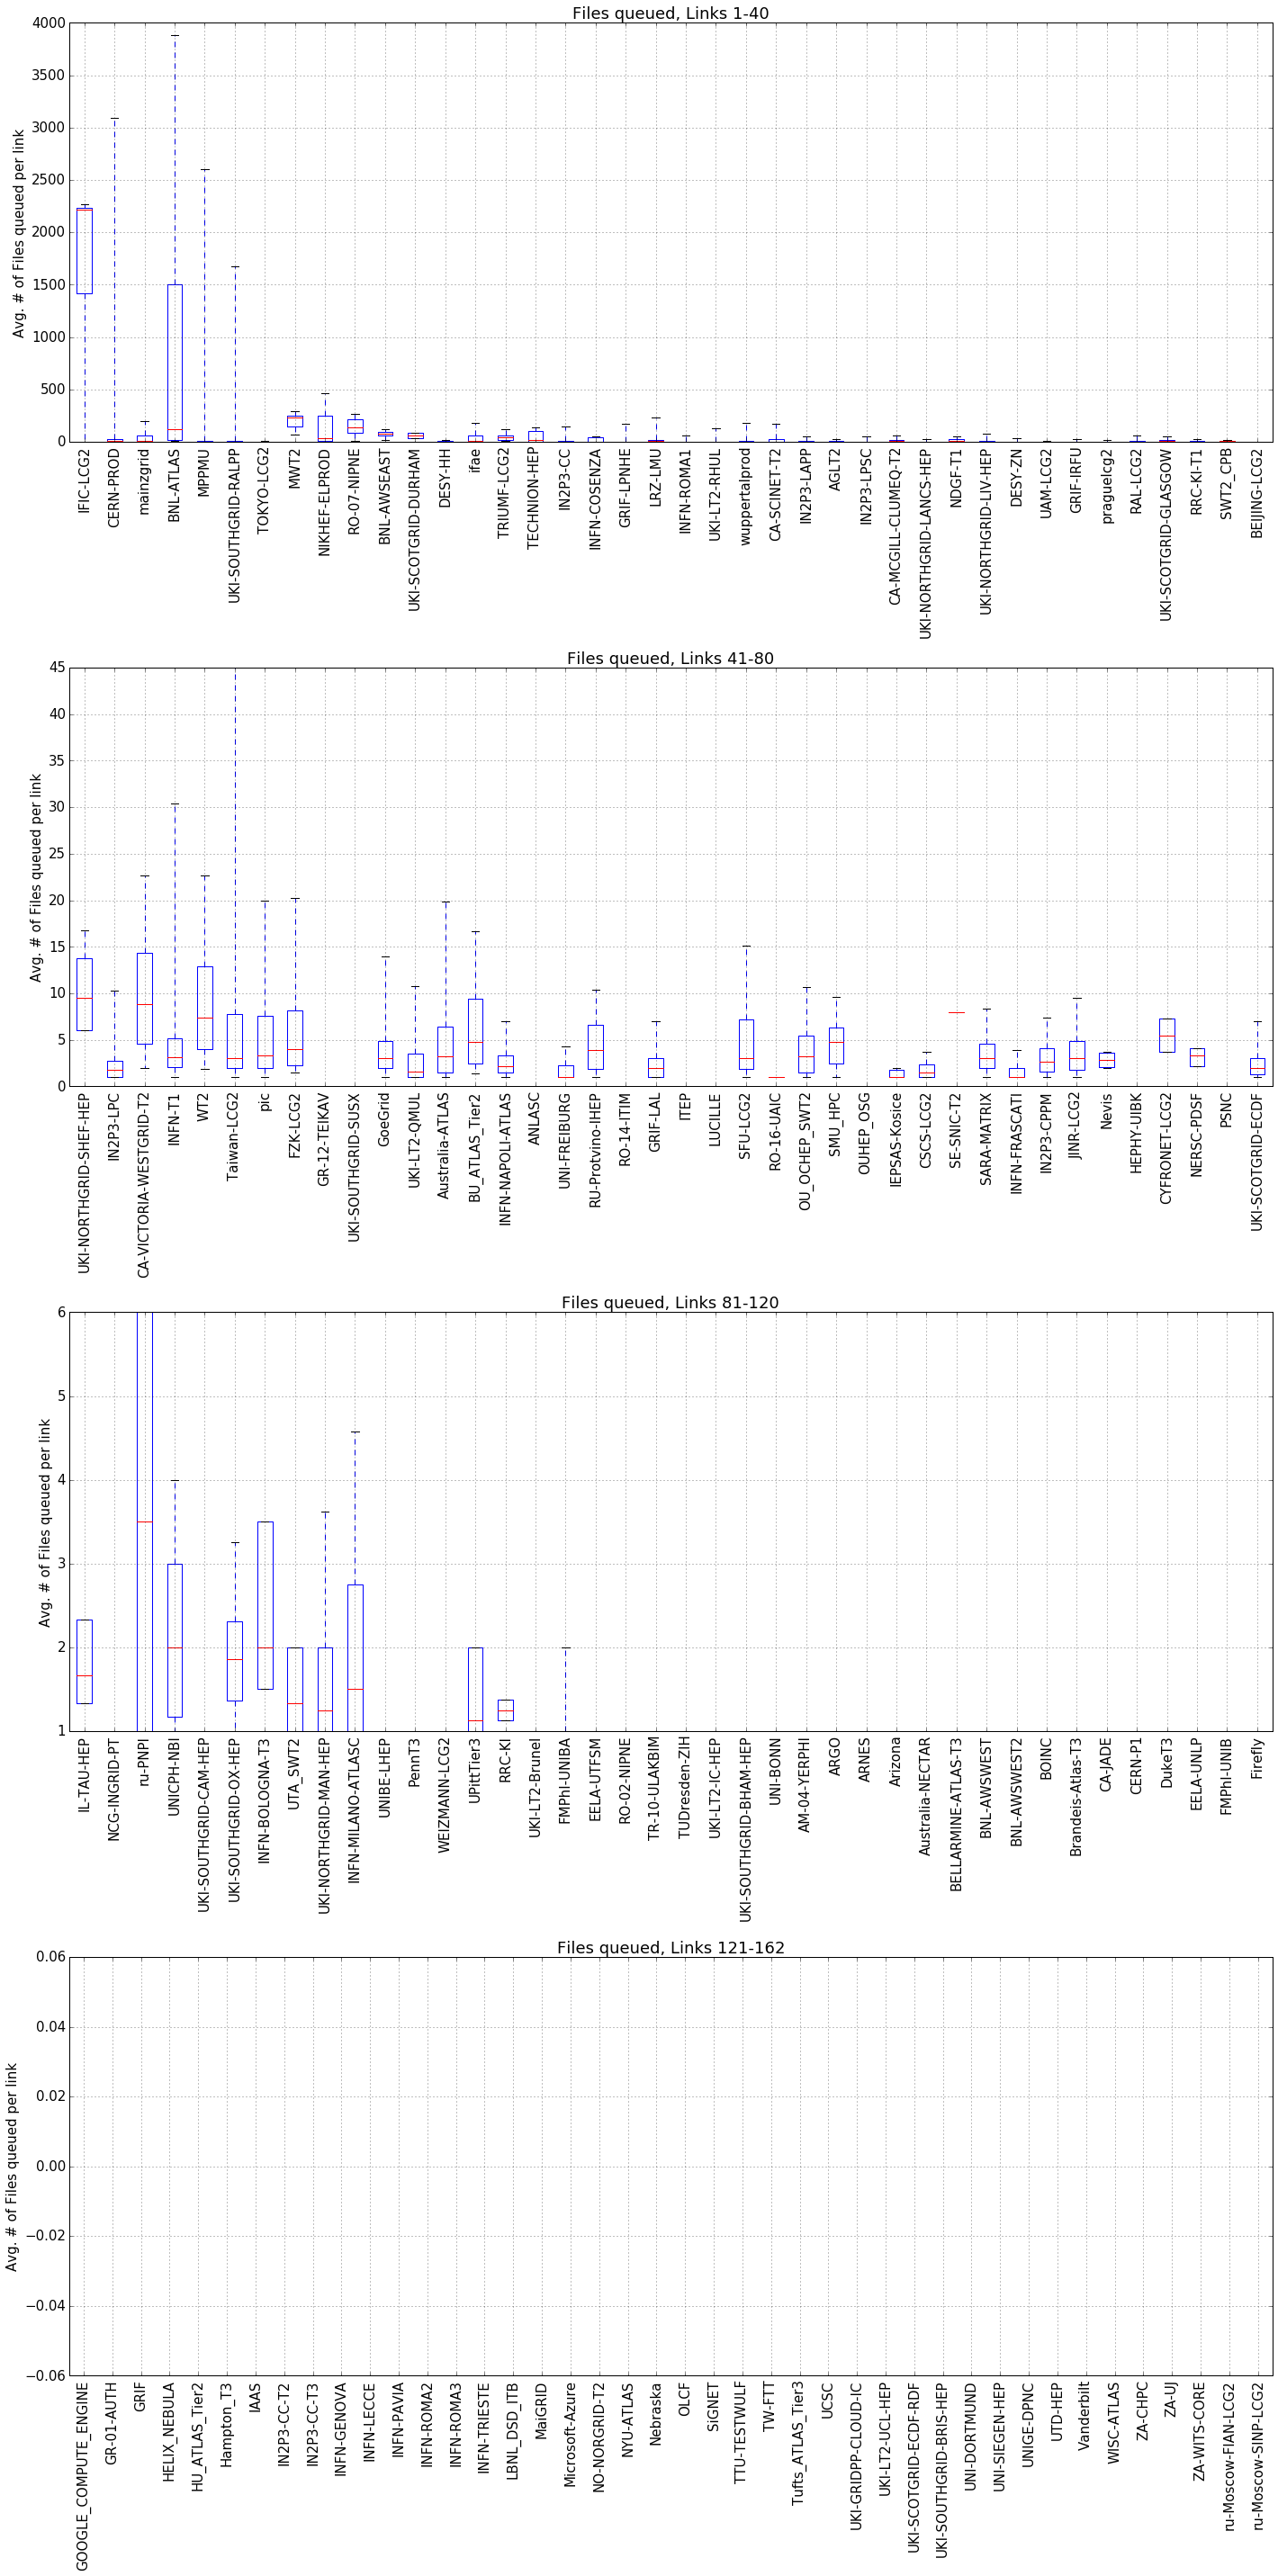

In [32]:
#Show summary for Fax MB/s
import matplotlib.pyplot as plt
plt.figure(figsize=(20,40))

plt.subplot(411)
plt.boxplot(totalQueuedData[0:40], whis=[5,95], showfliers=False)
ax = plt.gca() 
ax.xaxis.set_ticklabels(sites[0:40])
plt.xticks(size=15,rotation= 90)
plt.grid()
plt.ylabel('Avg. # of Files queued per link')
plt.title('Files queued, Links 1-40')

plt.subplot(412)
plt.boxplot(totalQueuedData[40:80], whis=[5,95], showfliers=False)
ax = plt.gca() 
ax.xaxis.set_ticklabels(sites[40:])
plt.xticks(size=15,rotation= 90)
plt.ylabel('Avg. # of Files queued per link')
plt.title('Files queued, Links 41-80')
plt.grid()

plt.subplot(413)
plt.boxplot(totalQueuedData[80:120], whis=[5,95], showfliers=False)
ax = plt.gca() 
ax.xaxis.set_ticklabels(sites[80:120])
plt.xticks(size=15,rotation= 90)
plt.ylabel('Avg. # of Files queued per link')
plt.title('Files queued, Links 81-120')
plt.grid()

plt.subplot(414)
plt.boxplot(totalQueuedData[120:], whis=[5,95], showfliers=False)
ax = plt.gca() 
ax.xaxis.set_ticklabels(sites[120:162])
plt.xticks(size=15,rotation= 90)
plt.ylabel('Avg. # of Files queued per link')
plt.title('Files queued, Links 121-162')
plt.grid()

plt.tight_layout()

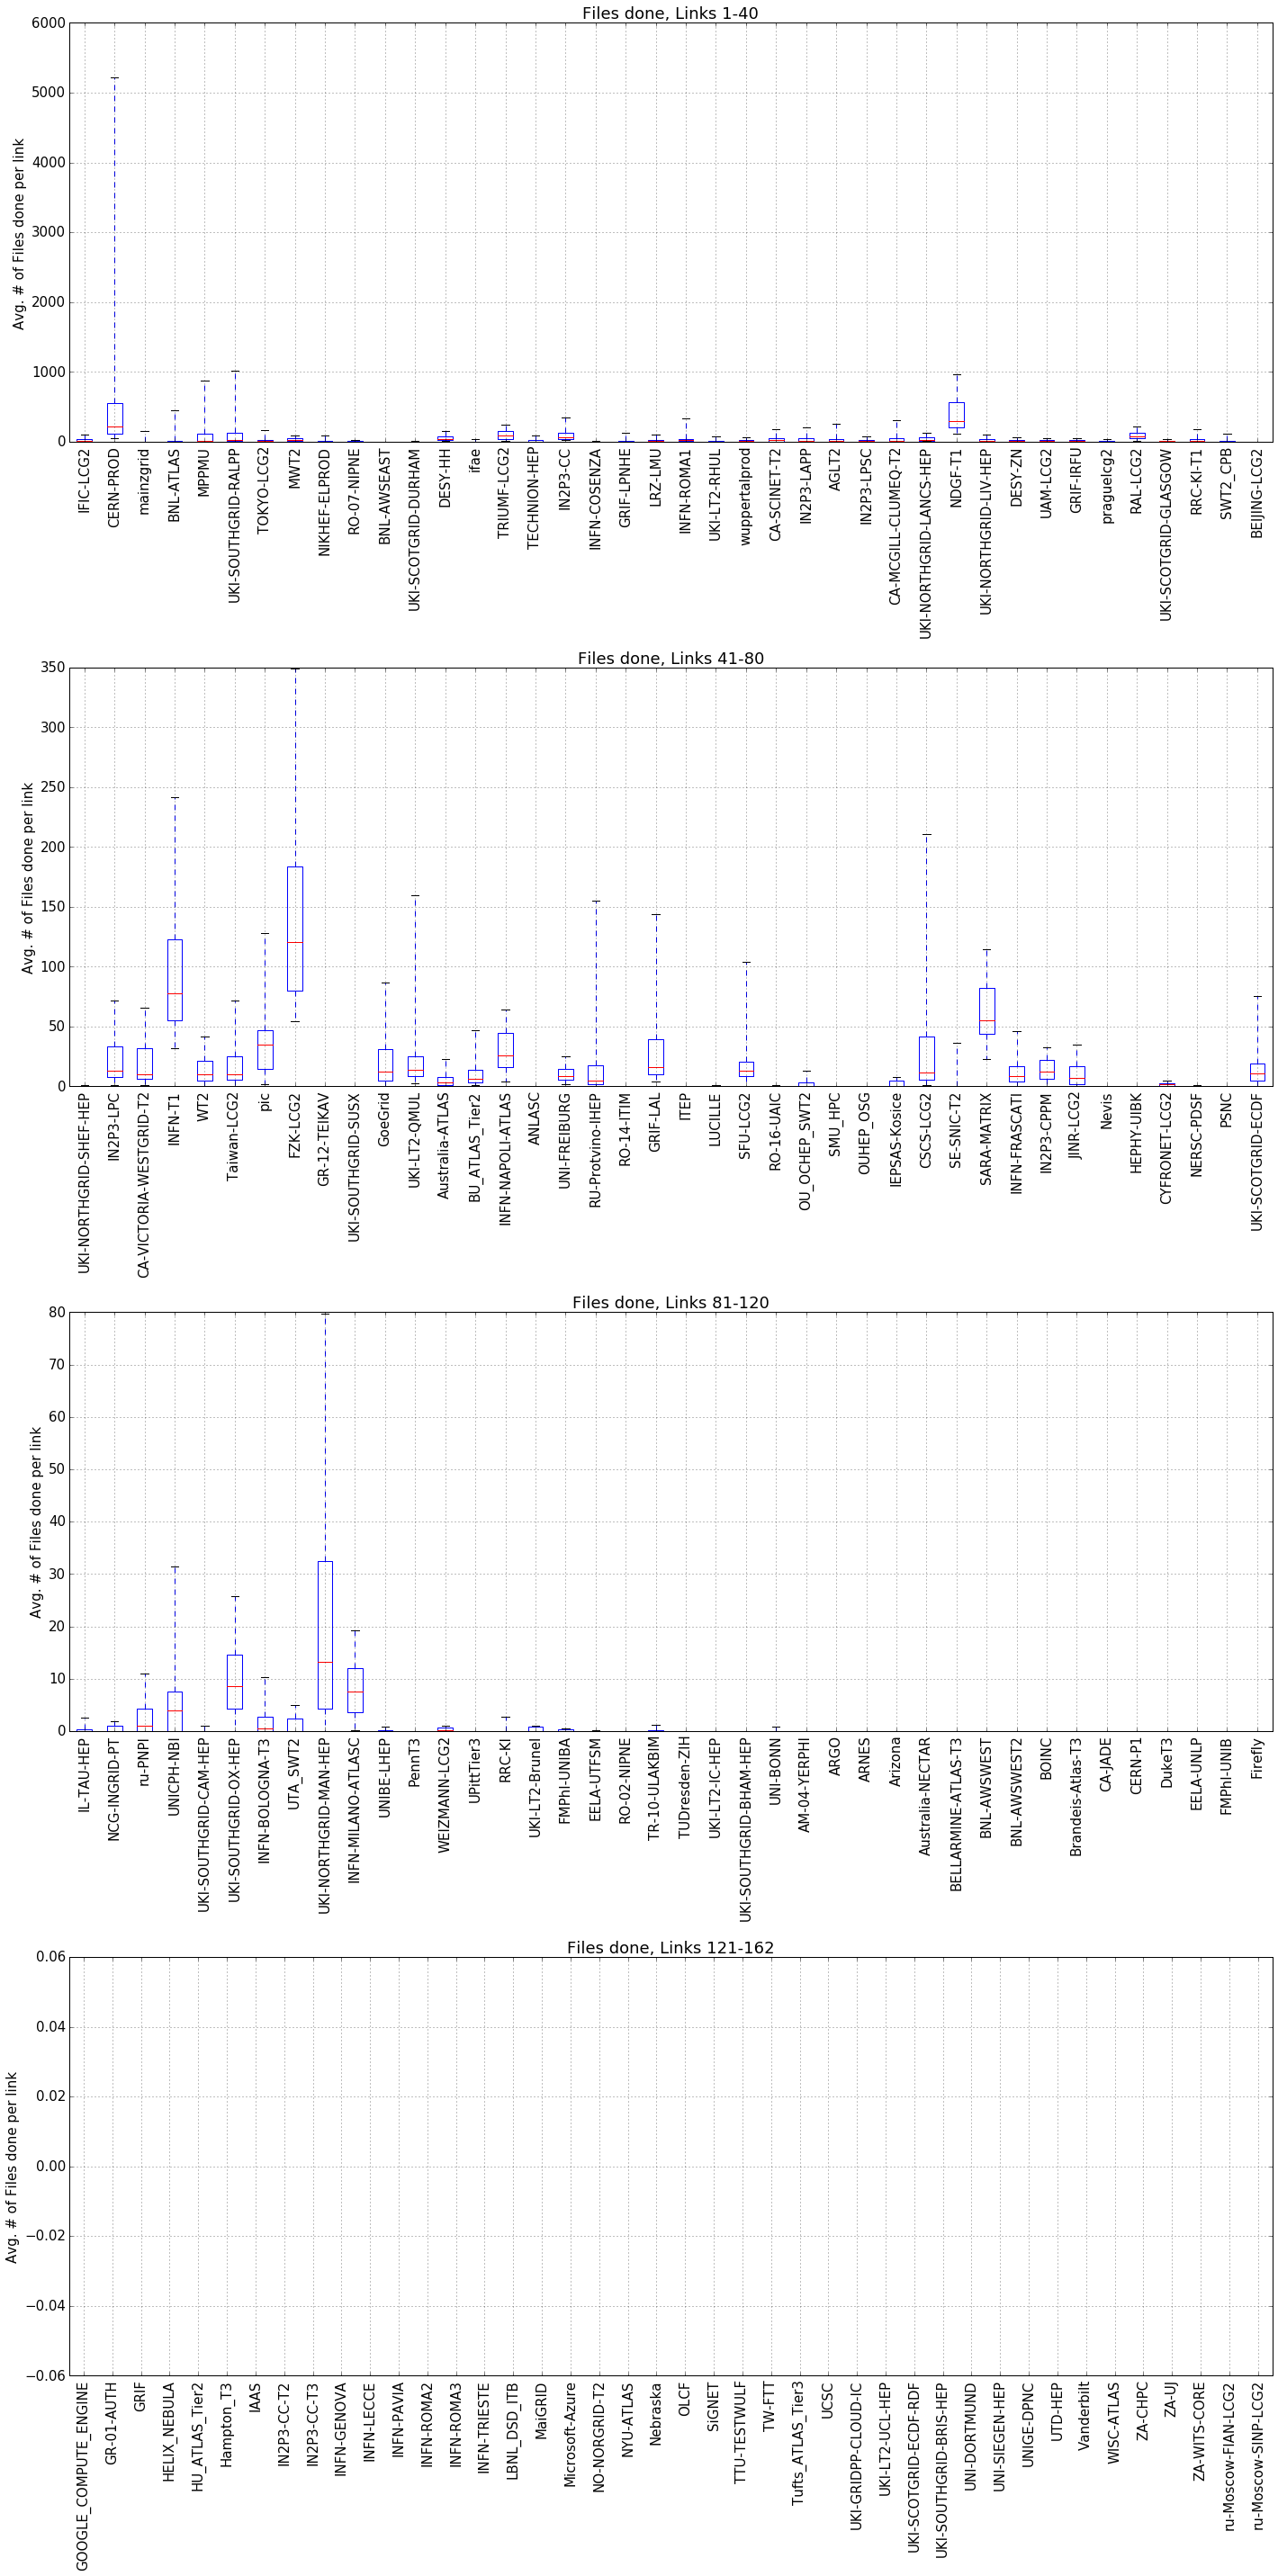

In [34]:
#Show summary for Fax MB/s
import matplotlib.pyplot as plt
plt.figure(figsize=(20,40))

plt.subplot(411)
plt.boxplot(totalDoneData[0:40], whis=[5,95], showfliers=False)
ax = plt.gca() 
ax.xaxis.set_ticklabels(sites[0:40])
plt.xticks(size=15,rotation= 90)
plt.grid()
plt.ylabel('Avg. # of Files done per link')
plt.title('Files done, Links 1-40')

plt.subplot(412)
plt.boxplot(totalDoneData[40:80], whis=[5,95], showfliers=False)
ax = plt.gca() 
ax.xaxis.set_ticklabels(sites[40:])
plt.xticks(size=15,rotation= 90)
plt.ylabel('Avg. # of Files done per link')
plt.title('Files done, Links 41-80')
plt.grid()

plt.subplot(413)
plt.boxplot(totalDoneData[80:120], whis=[5,95], showfliers=False)
ax = plt.gca() 
ax.xaxis.set_ticklabels(sites[80:120])
plt.xticks(size=15,rotation= 90)
plt.ylabel('Avg. # of Files done per link')
plt.title('Files done, Links 81-120')
plt.grid()

plt.subplot(414)
plt.boxplot(totalDoneData[120:], whis=[5,95], showfliers=False)
ax = plt.gca() 
ax.xaxis.set_ticklabels(sites[120:162])
plt.xticks(size=15,rotation= 90)
plt.ylabel('Avg. # of Files done per link')
plt.title('Files done, Links 121-162')
plt.grid()

plt.tight_layout()

In [15]:
queuedHist = dict(zip(sites, totalQueuedData))

timestampHist = dict(zip(sites, totalTimestamp))

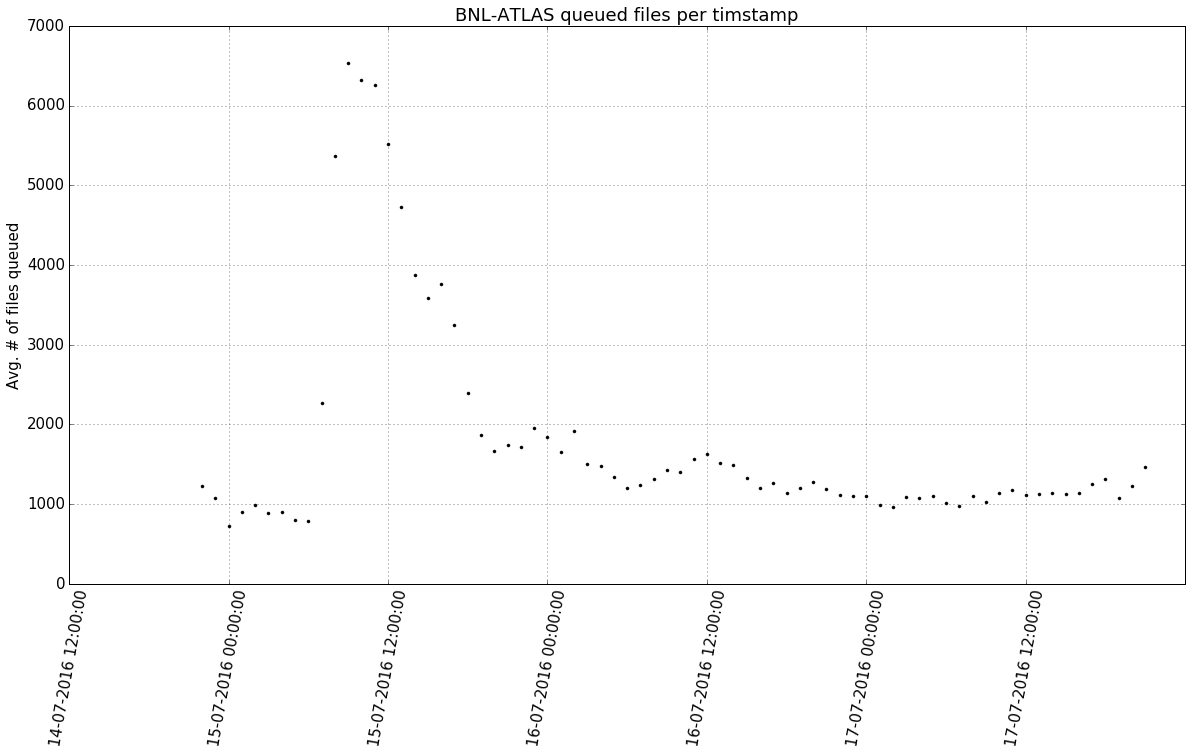

In [31]:
import matplotlib.dates as dt

centerName = 'BNL-ATLAS'

queuedTimestamp = dt.epoch2num(timestampHist[centerName]/1000.)
queuedData = queuedHist[centerName]

plt.figure(figsize=(20,10))

plt.plot(queuedTimestamp,queuedData,'k.')

ax = plt.gca()
#Tedious date/time formatting
xfmt = dt.DateFormatter('%d-%m-%Y %H:%M:%S')
ax.xaxis.set_major_formatter(xfmt)
ax.xaxis_date()

plt.ylabel('Avg. # of files queued')
ticks = 1/2
#Manually add extra ticks to histogram plots
start, end = ax.get_xlim()
plt.xticks(np.arange(start, end,ticks),rotation= 80 )
plt.grid()
plt.title('%s queued files per timstamp'%centerName)
plt.show()